<a href="https://colab.research.google.com/github/Romi2222/CSC-521/blob/main/CSC_521_Customer_Segmentation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Saving Mall_Customers.csv to Mall_Customers.csv
First 5 rows of the dataset:
   CustomerID   Genre  Age  Annual Income (k$)  Spending Score (1-100)
0           1    Male   19                  15                      39
1           2    Male   21                  15                      81
2           3  Female   20                  16                       6
3           4  Female   23                  16                      77
4           5  Female   31                  17                      40

Columns: ['CustomerID', 'Genre', 'Age', 'Annual Income (k$)', 'Spending Score (1-100)']

Feature matrix shape (n_samples, n_features): (200, 2)

=== Clustering Results (mean over 5 runs) ===
Algorithm  k  Mean Silhouette  Mean Runtime (s)
  K-Means  3           0.4666            0.0227
 Spectral  3           0.4576            0.0329
  K-Means  4           0.4939            0.0178
 Spectral  4           0.4666            0.0234
  K-Means  5           0.5547            0.0188
 Spectral  5     

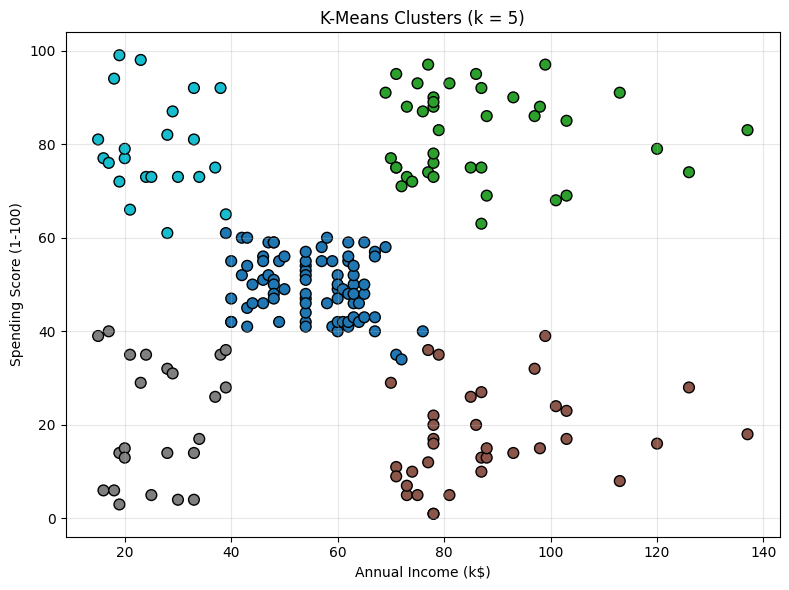

In [1]:

# K-Means vs Spectral Clustering
# for Customer Segmentation (Mall Customers)

import time

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans, SpectralClustering
from sklearn.metrics import silhouette_score

# 1. Load dataset
from google.colab import files
uploaded = files.upload()
df = pd.read_csv("Mall_Customers.csv")

print("First 5 rows of the dataset:")
print(df.head())
print("\nColumns:", df.columns.tolist())

# 2) Select features: Annual Income and Spending Score
feature_cols = ["Annual Income (k$)", "Spending Score (1-100)"]
X = df[feature_cols].values

# 3) Standardize features (zero mean, unit variance)
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

print("\nFeature matrix shape (n_samples, n_features):", X_scaled.shape)

# 4) Run K-Means and Spectral Clustering for k = 3, 4, 5
#    Multiple runs per configuration to average randomness
k_values = [3, 4, 5]
n_runs = 5  # number of random seeds to average over

results = []

for k in k_values:
    #  K-Means
    sil_scores = []
    runtimes = []
    for seed in range(n_runs):
        start = time.time()
        kmeans = KMeans(
            n_clusters=k,
            init="k-means++",
            n_init=10,
            max_iter=300,
            random_state=seed
        )
        labels = kmeans.fit_predict(X_scaled)
        end = time.time()

        sil = silhouette_score(X_scaled, labels)
        rt = end - start

        sil_scores.append(sil)
        runtimes.append(rt)

    results.append({
        "Algorithm": "K-Means",
        "k": k,
        "Mean Silhouette": np.mean(sil_scores),
        "Mean Runtime (s)": np.mean(runtimes)
    })

    # Spectral Clustering
    sil_scores = []
    runtimes = []
    for seed in range(n_runs):
        start = time.time()
        spectral = SpectralClustering(
            n_clusters=k,
            affinity="rbf",
            gamma=1.0,       # RBF kernel parameter
            assign_labels="kmeans",
            random_state=seed
        )
        labels = spectral.fit_predict(X_scaled)
        end = time.time()

        sil = silhouette_score(X_scaled, labels)
        rt = end - start

        sil_scores.append(sil)
        runtimes.append(rt)

    results.append({
        "Algorithm": "Spectral",
        "k": k,
        "Mean Silhouette": np.mean(sil_scores),
        "Mean Runtime (s)": np.mean(runtimes)
    })

# 5) Show results as a table
results_df = pd.DataFrame(results)
print("\n=== Clustering Results (mean over", n_runs, "runs) ===")
print(results_df.to_string(index=False, float_format="{:.4f}".format))

# 6) Find the best configuration by Silhouette Score
best_idx = results_df["Mean Silhouette"].idxmax()
best_row = results_df.iloc[best_idx]

best_algo = best_row["Algorithm"]
best_k = int(best_row["k"])

print(f"\nBest configuration: {best_algo} with k={best_k}")
print(f"Mean Silhouette = {best_row['Mean Silhouette']:.4f}")
print(f"Mean Runtime    = {best_row['Mean Runtime (s)']:.4f} seconds")

# 7) Re-run the best method once to get labels for plotting
if best_algo == "K-Means":
    model = KMeans(
        n_clusters=best_k,
        init="k-means++",
        n_init=10,
        max_iter=300,
        random_state=0
    )
    labels_best = model.fit_predict(X_scaled)
else:
    model = SpectralClustering(
        n_clusters=best_k,
        affinity="rbf",
        gamma=1.0,
        assign_labels="kmeans",
        random_state=0
    )
    labels_best = model.fit_predict(X_scaled)

# 8) Plot clusters in 2D
plt.figure(figsize=(8, 6))
scatter = plt.scatter(
    X[:, 0],      # Annual Income (k$)
    X[:, 1],      # Spending Score (1-100)
    c=labels_best,
    cmap="tab10",
    s=60,
    edgecolors="k"
)
plt.title(f"{best_algo} Clusters (k = {best_k})")
plt.xlabel("Annual Income (k$)")
plt.ylabel("Spending Score (1-100)")
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()
